# GraphBench - Electronic Circuits

In this notebook, we explore the **[Electronic Circuits benchmark](https://graphbench.github.io/website/datasets.html#ds-circuits)** from GraphBench. The benchmark consists of two regression tasks: given an electronic circuit represented as a graph, the goal is to predict the voltage conversion ratio and the power conversion efficiency.

To run this notebook, please install the project dependencies. Se README.md for details.

## 1. Load the Data

We are following the setup detailed on the [GraphBench website](https://graphbench.github.io/website/quickstart.html), with some attional changes. At the time of writing the library has not added the Optimizer, hence we skip that for now.

We start with the circuits of size five nodes, and with the power conversion efficiency task.

In [1]:
import graphbench
import os

dataset_name = "electronic_circuits_5_eff"  # name of the task or list of tasks
evaluator_name = "electroniccircuit"

# Use relative path to data directory (from project root)
data_path = "./data"

# Setting up the components of GraphBench
Evaluator = graphbench.Evaluator("electroniccircuit")
Loader = graphbench.Loader(data_path, dataset_name)

# Load a GraphBench dataset and get splits
dataset = Loader.load()

## Data Analysis

In [2]:
dataset

[{'train': ECDataset(234093),
  'valid': ECDataset(33442),
  'test': ECDataset(66884)}]

In [3]:
single_graph_data = dataset[0]["train"][1]
single_graph_data

Data(x=[9, 1, 9], edge_index=[2, 20], y=[1], duty=[1], device_ids=[5], device_ids_len=[1], port_ids=[4], port_ids_len=[1], terminal_ids=[3], terminal_ids_len=[1])

In [4]:
print("Power Efficency, y: ", single_graph_data.y)
print("Duty: ", single_graph_data.duty)
print("Device IDs: ", single_graph_data.device_ids)
print("Port IDs: ",  single_graph_data.port_ids)
print("X: ", single_graph_data.x)

Power Efficency, y:  tensor([0.9834])
Duty:  tensor([0.1000])
Device IDs:  tensor([0, 1, 2, 3, 4])
Port IDs:  tensor([5, 6, 7, 8])
X:  tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0.]]])


This example circuit contains five device nodes and four ports. Each node has a node type vector in **X**.

In addition to the circuit, the graph also comes with a **Duty** scalar value. We should concider this value in the modeling stage.

## Visualize the circuit

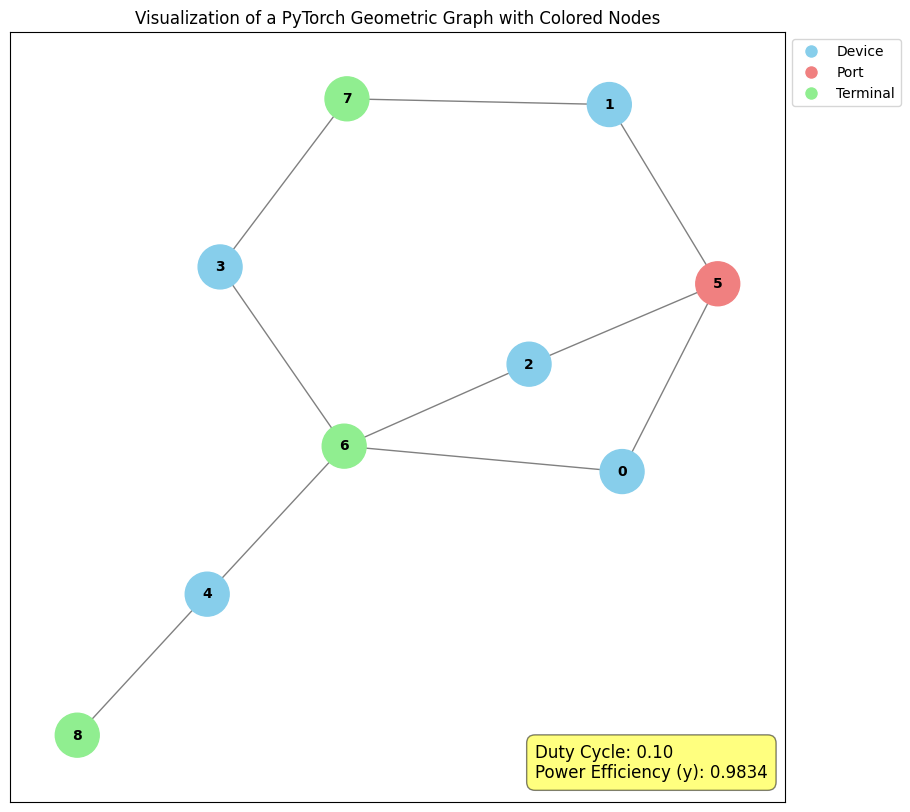

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph from the edge_index
g = nx.Graph()
# Add nodes. The number of nodes is inferred from the max node index in edge_index
num_nodes = single_graph_data.num_nodes
g.add_nodes_from(range(num_nodes))

# Add edges from edge_index
# edge_index is typically [2, num_edges], where row 0 are source nodes and row 1 are target nodes
# Transpose and convert to a list of tuples for NetworkX
edges = single_graph_data.edge_index.t().tolist()
g.add_edges_from(edges)

# Assign colors based on node type (device_ids, port_ids, terminal_ids)
node_colors = ['lightgray'] * num_nodes # Default color

device_ids = single_graph_data.device_ids.tolist()
port_ids = single_graph_data.port_ids.tolist()
terminal_ids = single_graph_data.terminal_ids.tolist()

for i in range(num_nodes):
    if i in device_ids:
        node_colors[i] = 'skyblue' # Color for devices
    if i in port_ids:
        node_colors[i] = 'lightcoral' # Color for ports
    if i in terminal_ids: # Terminals can be ports, so this might override port color if present in both
        node_colors[i] = 'lightgreen' # Color for terminals

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(g, pos, edge_color='gray')
nx.draw_networkx_labels(g, pos, font_size=10, font_weight='bold')
plt.title("Visualization of a PyTorch Geometric Graph with Colored Nodes")

# Legend
legend_handles = []
if device_ids: legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Device',
                          markerfacecolor='skyblue', markersize=10))
if port_ids: legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Port',
                          markerfacecolor='lightcoral', markersize=10))
if terminal_ids: legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Terminal',
                          markerfacecolor='lightgreen', markersize=10))

if legend_handles:
    plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))

# Add the duty and power efficiency values to the plot
duty_value = single_graph_data.duty.item()
y_value = single_graph_data.y.item()

# Format for display
text_str = f"Duty Cycle: {duty_value:.2f}\nPower Efficiency (y): {y_value:.4f}"

# Add text box for duty and power efficiency
# transform=plt.gcf().transFigure places it relative to the figure (0-1, 0-1)
plt.figtext(0.65, 0.13, text_str, fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5), ha='left', va='bottom')

plt.show()

## Setup Model

We setup a Graph Isomorphism Network as baseline model.

In [6]:
import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
import copy


class GINGraphRegressor(torch.nn.Module):
    def __init__(self, in_channels, hidden=64, out_channels=1, num_layers=3, dropout=0.5):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            mlp = Sequential(
                Linear(in_channels if i == 0 else hidden, hidden),
                BatchNorm1d(hidden),
                ReLU(),
                Linear(hidden, hidden),
                ReLU(),
            )
            self.convs.append(GINConv(mlp))

        # hidden + 1 because we concatenate the duty cycle
        self.lin1 = Linear(hidden + 1, hidden)
        self.lin2 = Linear(hidden, out_channels)
        self.dropout = dropout

    def forward(self, data, duty):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = x.squeeze(1)
        
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        g = global_mean_pool(x, batch)   # graph embedding

        # Concatenate duty cycle to the graph embedding
        g = torch.cat([g, duty.view(-1, 1)], dim=1)
        g = F.relu(self.lin1(g))
        g = F.dropout(g, p=self.dropout, training=self.training)
        g = self.lin2(g)

        return torch.sigmoid(g)

In [7]:
# Infer in_channels from the dataset
first_graph_node_features = dataset[0]['train'][0].x
in_channels = first_graph_node_features.shape[2]
out_channels = 1

### Cleaning Corrupted Data
Some of the training data contained `nan` values. Hence we filter them out before training.

In [8]:
from tqdm.notebook import tqdm

# Clean the dataset
def clean_dataset(data_list, name="Data"):
    cleaned = []
    for data in tqdm(data_list, desc=f"Cleaning {name}"):
        # Check for NaNs in x, y, duty and check for empty graphs
        if not (torch.isnan(data.x).any() or torch.isnan(data.y).any() or torch.isnan(data.duty).any() or data.num_nodes == 0):
            cleaned.append(data)
    print(f"{name}: Original size {len(data_list)}, Cleaned size {len(cleaned)}")
    return cleaned

print("Filtering corrupted data...")
# Cleaning the datasets (this might take a minute)
train_data = clean_dataset(dataset[0]['train'], "Train")
val_data = clean_dataset(dataset[0]['valid'], "Val")
test_data = clean_dataset(dataset[0]['test'], "Test")

Filtering corrupted data...


Cleaning Train:   0%|          | 0/234093 [00:00<?, ?it/s]

Train: Original size 234093, Cleaned size 234084


Cleaning Val:   0%|          | 0/33442 [00:00<?, ?it/s]

Val: Original size 33442, Cleaned size 33442


Cleaning Test:   0%|          | 0/66884 [00:00<?, ?it/s]

Test: Original size 66884, Cleaned size 66884


## Training Loop

In [9]:
model = GINGraphRegressor(
    in_channels=in_channels,
    out_channels=out_channels,
    hidden=64,
    num_layers=3,
    dropout=0.5,
)  # Use inferred channels

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

# Create DataLoaders using the cleaned data
train_loader = torch_geometric.loader.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch_geometric.loader.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch_geometric.loader.DataLoader(test_data, batch_size=128, shuffle=False)

def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Training", display=True): # Wrap loader with tqdm
        optimizer.zero_grad()
        out = model(data, data.duty.float())
        # Reshape data.y to match out shape [batch_size, 1]
        loss = loss_fn(out, data.y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, loss_fn): 
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating", display=True): # Wrap loader with tqdm
            out = model(data, data.duty.float())
            # Reshape data.y to match out shape [batch_size, 1]
            loss = loss_fn(out, data.y.float().view(-1, 1))
            total_loss += loss.item() * data.num_graphs
            # Squeeze if the output is (batch_size, 1) to match data.y (batch_size)
            all_preds.append(out.squeeze(-1) if out.dim() > 1 and out.shape[1] == 1 else out)
            all_labels.append(data.y.float())
    return total_loss / len(loader.dataset), torch.cat(all_labels), torch.cat(all_preds)

# Training loop with Early Stopping
num_epochs = 100
patience = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    loss = train(model, train_loader, optimizer, loss_fn)
    val_loss, _, _ = evaluate(model, val_loader, loss_fn)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Validation loss improved. Saving model.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights.")

# Evaluate on the test set
test_loss, y_true, y_pred = evaluate(model, test_loader, loss_fn)
print(f'Test Loss: {test_loss:.4f}')

# Now you can use graphbench.Evaluator with y_true and y_pred
Evaluator = graphbench.Evaluator("electroniccircuit") # Re-instantiate if needed
# Ensure y_true and y_pred are flattened if they are (N, 1) and expected to be (N,)
results = Evaluator.evaluate(y_pred.view(-1, 1).cpu().numpy(), y_true.view(-1, 1).cpu().numpy()) # Convert to numpy for graphbench
print("GraphBench Evaluation Results:", results)

Epoch 1/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 001, Loss: 0.0631, Val Loss: 0.0311
Validation loss improved. Saving model.
Epoch 2/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 002, Loss: 0.0302, Val Loss: 0.0280
Validation loss improved. Saving model.
Epoch 3/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 003, Loss: 0.0248, Val Loss: 0.0211
Validation loss improved. Saving model.
Epoch 4/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 004, Loss: 0.0215, Val Loss: 0.0180
Validation loss improved. Saving model.
Epoch 5/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 005, Loss: 0.0189, Val Loss: 0.0156
Validation loss improved. Saving model.
Epoch 6/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 006, Loss: 0.0171, Val Loss: 0.0150
Validation loss improved. Saving model.
Epoch 7/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 007, Loss: 0.0157, Val Loss: 0.0130
Validation loss improved. Saving model.
Epoch 8/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 008, Loss: 0.0144, Val Loss: 0.0120
Validation loss improved. Saving model.
Epoch 9/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 009, Loss: 0.0136, Val Loss: 0.0130
Validation loss did not improve. Counter: 1/3
Epoch 10/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 010, Loss: 0.0127, Val Loss: 0.0111
Validation loss improved. Saving model.
Epoch 11/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 011, Loss: 0.0122, Val Loss: 0.0112
Validation loss did not improve. Counter: 1/3
Epoch 12/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 012, Loss: 0.0117, Val Loss: 0.0102
Validation loss improved. Saving model.
Epoch 13/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 013, Loss: 0.0113, Val Loss: 0.0100
Validation loss improved. Saving model.
Epoch 14/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 014, Loss: 0.0107, Val Loss: 0.0102
Validation loss did not improve. Counter: 1/3
Epoch 15/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 015, Loss: 0.0105, Val Loss: 0.0094
Validation loss improved. Saving model.
Epoch 16/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 016, Loss: 0.0101, Val Loss: 0.0090
Validation loss improved. Saving model.
Epoch 17/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 017, Loss: 0.0098, Val Loss: 0.0086
Validation loss improved. Saving model.
Epoch 18/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 018, Loss: 0.0095, Val Loss: 0.0083
Validation loss improved. Saving model.
Epoch 19/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 019, Loss: 0.0092, Val Loss: 0.0086
Validation loss did not improve. Counter: 1/3
Epoch 20/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 020, Loss: 0.0091, Val Loss: 0.0079
Validation loss improved. Saving model.
Epoch 21/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 021, Loss: 0.0088, Val Loss: 0.0078
Validation loss improved. Saving model.
Epoch 22/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 022, Loss: 0.0085, Val Loss: 0.0076
Validation loss improved. Saving model.
Epoch 23/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 023, Loss: 0.0084, Val Loss: 0.0073
Validation loss improved. Saving model.
Epoch 24/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 024, Loss: 0.0081, Val Loss: 0.0072
Validation loss improved. Saving model.
Epoch 25/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 025, Loss: 0.0079, Val Loss: 0.0071
Validation loss improved. Saving model.
Epoch 26/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 026, Loss: 0.0078, Val Loss: 0.0069
Validation loss improved. Saving model.
Epoch 27/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 027, Loss: 0.0076, Val Loss: 0.0070
Validation loss did not improve. Counter: 1/3
Epoch 28/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 028, Loss: 0.0075, Val Loss: 0.0067
Validation loss improved. Saving model.
Epoch 29/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 029, Loss: 0.0074, Val Loss: 0.0065
Validation loss improved. Saving model.
Epoch 30/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 030, Loss: 0.0072, Val Loss: 0.0065
Validation loss did not improve. Counter: 1/3
Epoch 31/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 031, Loss: 0.0071, Val Loss: 0.0064
Validation loss improved. Saving model.
Epoch 32/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 032, Loss: 0.0071, Val Loss: 0.0063
Validation loss improved. Saving model.
Epoch 33/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 033, Loss: 0.0069, Val Loss: 0.0061
Validation loss improved. Saving model.
Epoch 34/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 034, Loss: 0.0069, Val Loss: 0.0062
Validation loss did not improve. Counter: 1/3
Epoch 35/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 035, Loss: 0.0068, Val Loss: 0.0059
Validation loss improved. Saving model.
Epoch 36/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 036, Loss: 0.0067, Val Loss: 0.0059
Validation loss improved. Saving model.
Epoch 37/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 037, Loss: 0.0067, Val Loss: 0.0062
Validation loss did not improve. Counter: 1/3
Epoch 38/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 038, Loss: 0.0066, Val Loss: 0.0059
Validation loss did not improve. Counter: 2/3
Epoch 39/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 039, Loss: 0.0065, Val Loss: 0.0057
Validation loss improved. Saving model.
Epoch 40/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 040, Loss: 0.0065, Val Loss: 0.0058
Validation loss did not improve. Counter: 1/3
Epoch 41/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 041, Loss: 0.0064, Val Loss: 0.0057
Validation loss improved. Saving model.
Epoch 42/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 042, Loss: 0.0063, Val Loss: 0.0056
Validation loss improved. Saving model.
Epoch 43/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 043, Loss: 0.0062, Val Loss: 0.0056
Validation loss did not improve. Counter: 1/3
Epoch 44/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 044, Loss: 0.0063, Val Loss: 0.0057
Validation loss did not improve. Counter: 2/3
Epoch 45/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 045, Loss: 0.0061, Val Loss: 0.0055
Validation loss improved. Saving model.
Epoch 46/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 046, Loss: 0.0061, Val Loss: 0.0055
Validation loss improved. Saving model.
Epoch 47/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 047, Loss: 0.0061, Val Loss: 0.0056
Validation loss did not improve. Counter: 1/3
Epoch 48/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 048, Loss: 0.0060, Val Loss: 0.0054
Validation loss improved. Saving model.
Epoch 49/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 049, Loss: 0.0058, Val Loss: 0.0054
Validation loss did not improve. Counter: 1/3
Epoch 50/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 050, Loss: 0.0059, Val Loss: 0.0053
Validation loss improved. Saving model.
Epoch 51/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 051, Loss: 0.0059, Val Loss: 0.0052
Validation loss improved. Saving model.
Epoch 52/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 052, Loss: 0.0057, Val Loss: 0.0051
Validation loss improved. Saving model.
Epoch 53/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 053, Loss: 0.0057, Val Loss: 0.0050
Validation loss improved. Saving model.
Epoch 54/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 054, Loss: 0.0056, Val Loss: 0.0049
Validation loss improved. Saving model.
Epoch 55/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 055, Loss: 0.0055, Val Loss: 0.0052
Validation loss did not improve. Counter: 1/3
Epoch 56/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 056, Loss: 0.0055, Val Loss: 0.0049
Validation loss improved. Saving model.
Epoch 57/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 057, Loss: 0.0054, Val Loss: 0.0050
Validation loss did not improve. Counter: 1/3
Epoch 58/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 058, Loss: 0.0054, Val Loss: 0.0047
Validation loss improved. Saving model.
Epoch 59/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 059, Loss: 0.0053, Val Loss: 0.0046
Validation loss improved. Saving model.
Epoch 60/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 060, Loss: 0.0053, Val Loss: 0.0048
Validation loss did not improve. Counter: 1/3
Epoch 61/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 061, Loss: 0.0052, Val Loss: 0.0048
Validation loss did not improve. Counter: 2/3
Epoch 62/100


Training:   0%|          | 0/1829 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch: 062, Loss: 0.0052, Val Loss: 0.0046
Validation loss did not improve. Counter: 3/3
Early stopping triggered.
Loaded best model weights.


Evaluating:   0%|          | 0/523 [00:00<?, ?it/s]

Test Loss: 0.0046
Using metric: ['RSE'] for task: regression
GraphBench Evaluation Results: 0.02442789077758789


/Users/sebastiannilsson/code/graphbench-models/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
